## Problem Statement:  



### Importing Libraries and Reading in Data:  

In [252]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from sklearn.naive_bayes import MultinomialNB

In [3]:
# reading in scraped data and dropping first column to set index
df = pd.read_csv('./reddit_dataframe.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)


In [4]:
# Checking that dataframe has been imported correctly
df.head()

,Titles,Text,Subreddit
0,Ready to prove you're Challenger? /r/LeagueofL...,"Hi Summoners,\n\nDrum roll please... we have s...",leagueoflegends
1,Patch 9.7 Bug Megathread,Greetings Summoners!\n\nWith every new patch R...,leagueoflegends
2,Add the ability to remove all client animations.,Having to wait a duration longer than a Morgan...,leagueoflegends
3,You know a champion is old when they still tal...,"Udyr, Cho’gath and Mordekaiser are all pretty ...",leagueoflegends
4,bbq Malice just locked in Tahm Kench jungle.,In the bbq OLIVERS vs APK PRINCE play-off seri...,leagueoflegends


Null values have already been dealt with during the web scraping section of code. No real data cleaning is necessary after dealing with null values.

In [5]:
# Data had duplicates when first scraped from website. All duplicates will now be removed
df.drop_duplicates(keep = 'first', inplace = True)

In [6]:
# Renumbering indexes for easier manipulation and less confusion in future.
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)
df.head()

,Titles,Text,Subreddit
0,Ready to prove you're Challenger? /r/LeagueofL...,"Hi Summoners,\n\nDrum roll please... we have s...",leagueoflegends
1,Patch 9.7 Bug Megathread,Greetings Summoners!\n\nWith every new patch R...,leagueoflegends
2,Add the ability to remove all client animations.,Having to wait a duration longer than a Morgan...,leagueoflegends
3,You know a champion is old when they still tal...,"Udyr, Cho’gath and Mordekaiser are all pretty ...",leagueoflegends
4,bbq Malice just locked in Tahm Kench jungle.,In the bbq OLIVERS vs APK PRINCE play-off seri...,leagueoflegends


In [7]:
# adding title and text length to each post
df['title_length'] = df['Titles'].map(lambda x: len(x))
df['text_length'] = df['Text'].map(lambda x: len(x))

In [8]:
# seeing stats for league of legends reddit posts
mask = df['Subreddit'] == 'leagueoflegends'
df[mask].describe()

,title_length,text_length
count,559.000000,559.000000
mean,50.114490,666.692308
std,29.651158,1783.406245
min,6.000000,11.000000
25%,30.000000,137.500000
50%,42.000000,298.000000
75%,63.000000,606.000000
max,195.000000,29711.000000


In [9]:
# seeing stats for dota 2 subreddit posts
mask = df['Subreddit'] == 'DotA2'
df[mask].describe()

,title_length,text_length
count,494.000000,494.000000
mean,46.309717,597.582996
std,29.715337,1190.991935
min,5.000000,9.000000
25%,26.000000,110.000000
50%,40.000000,223.500000
75%,58.000000,473.250000
max,260.000000,9314.000000


In [10]:
# Creating a function to lemmatize texts and titles
def lemmatize(text):
    tokenizer = RegexpTokenizer(r'(\$?(\d+[\.,]?)+%?|(\/?\w+)+)')
    token = tokenizer.tokenize(text)
    new_token = [i[0] for i in token]
    lemmatizer = WordNetLemmatizer()
    lem_token = [lemmatizer.lemmatize(i) for i in new_token]
    return (" ".join(lem_token))

In [11]:
# Testing that function works
lemmatize(df['Text'][0])

'Hi Summoners Drum roll please we have something really exciting to announce We ve partnered with Battlefy and ZOTAC to present the /r/LeagueofLegends Cup We ve been looking forward to organizing a subreddit tournament and now is your chance to prove you re the best and win some at the same time The tournament is for both EUW and NA with EUW being on Saturday 06 April and NA being on Sunday 07 April If there is enough interest we would like to open up more tournament This is going to be a 5 v5 Tournament Draft with some more detail below EUW What EUW Tournament 5 v5 Tournament Draft When 06 April 1 pm CEST Where Click here to sign up and for more info http /battlefy com/zotac cup/zotac cup present rleagueoflegends tournament europe/5c96c7a0bf44520328f43849/info infoTab rule NA What NA Tournament 5 v5 Tournament Draft When 07 April 12 pm PDT 3 PM EDT Where Click here to sign up and for more info http /battlefy com/zotac cup/zotac cup present rleagueoflegends tournament north america/5c9

In [12]:
# Creating function to stem texts and titles
def porterStemming(text):
    tokenizer = RegexpTokenizer(r'(\$?(\d+[\.,]?)+%?|(\/?\w+)+)')
    token = tokenizer.tokenize(text)
    new_token = [i[0] for i in token]
    
    p_stemmer = PorterStemmer()
    port_token = [p_stemmer.stem(i) for i in new_token]
    return (" ".join(port_token))

In [13]:
# Testing to see that function works
porterStemming(lemmatize(df['Text'][0]))

'Hi summon drum roll pleas we have someth realli excit to announc We ve partner with battlefi and zotac to present the /r/leagueoflegend cup We ve been look forward to organ a subreddit tournament and now is your chanc to prove you re the best and win some at the same time the tournament is for both euw and NA with euw be on saturday 06 april and NA be on sunday 07 april If there is enough interest we would like to open up more tournament thi is go to be a 5 v5 tournament draft with some more detail below euw what euw tournament 5 v5 tournament draft when 06 april 1 pm cest where click here to sign up and for more info http /battlefi com/zotac cup/zotac cup present rleagueoflegend tournament europe/5c96c7a0bf44520328f43849/info infotab rule NA what NA tournament 5 v5 tournament draft when 07 april 12 pm pdt 3 PM edt where click here to sign up and for more info http /battlefi com/zotac cup/zotac cup present rleagueoflegend tournament north america/5c96cbbcde5210034390a000/info infotab 

### Judging between the two types of root words, lemmatizing seems to be the better choice since porter stemming has cut down the word into gibberish as show im the example text above.

In [14]:
# Lemmatizing all titles and texts in the dataframe
df['Titles'] = df['Titles'].map(lambda x: lemmatize(x))
df['Text'] = df['Text'].map(lambda x: lemmatize(x))


In [15]:
# checking to see thta all punctuations have been removed correctly
df.head()

,Titles,Text,Subreddit,title_length,text_length
0,Ready to prove you re Challenger /r/LeagueofLe...,Hi Summoners Drum roll please we have somethin...,leagueoflegends,106,3527
1,Patch 9.7 Bug Megathread,Greetings Summoners With every new patch Riot ...,leagueoflegends,24,3511
2,Add the ability to remove all client animation,Having to wait a duration longer than a Morgan...,leagueoflegends,48,311
3,You know a champion is old when they still tal...,Udyr Cho gath and Mordekaiser are all pretty o...,leagueoflegends,63,80
4,bbq Malice just locked in Tahm Kench jungle,In the bbq OLIVERS v APK PRINCE play off serie...,leagueoflegends,44,199


In [16]:
# creating dummy variables for the subreddit. Changing it so that it is a binary class
df = pd.get_dummies(df, columns = ['Subreddit'], drop_first = True)
df.head()

,Titles,Text,title_length,text_length,Subreddit_leagueoflegends
0,Ready to prove you re Challenger /r/LeagueofLe...,Hi Summoners Drum roll please we have somethin...,106,3527,1
1,Patch 9.7 Bug Megathread,Greetings Summoners With every new patch Riot ...,24,3511,1
2,Add the ability to remove all client animation,Having to wait a duration longer than a Morgan...,48,311,1
3,You know a champion is old when they still tal...,Udyr Cho gath and Mordekaiser are all pretty o...,63,80,1
4,bbq Malice just locked in Tahm Kench jungle,In the bbq OLIVERS v APK PRINCE play off serie...,44,199,1


In [17]:
# creating dataframe of just league of legends posts
mask = df['Subreddit_leagueoflegends'] == 1
league_df = df[mask]

In [18]:
# creating dataframe of just dota2 posts
mask = df['Subreddit_leagueoflegends'] == 0
dota_df = df[mask]

## EDA and counting words

In [269]:
# Checking to see the most used words in each individual data frame
# Setting X and y values
features = ['Text']
X = league_df[features]
y = league_df['Subreddit_leagueoflegends']

In [270]:
# Instatiating train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [271]:
# Using count vectorization as first model for text only
cv = CountVectorizer(stop_words = 'english')
cv.fit(X_train['Text'])
X_train_cv_text = cv.transform(X_train['Text'])
X_test_cv_text = cv.transform(X_test['Text'])

In [272]:
X_train_df = pd.DataFrame(X_train_cv_text.todense(), columns=cv.get_feature_names(),index = X_train.index)

In [273]:
X_train_df.sum().sort_values(ascending = False)

uh             6558
http            351
game            268
com             210
wa              209
team            205
just            202
like            175
skin            159
amp             154
mt              149
champion        140
play            140
time            134
x200b           122
ha              121
www             100
know             87
match            87
damage           85
player           83
really           82
change           82
think            81
10               81
league           78
new              76
twitch           75
make             75
people           75
               ... 
maining           1
masquerade        1
massiv            1
massively         1
media             1
mentally          1
members           1
melon             1
mejai             1
meh               1
meeting           1
medium            1
meditation        1
mediocre          1
medication        1
medic             1
meddle            1
masterwork        1
med               1


In [274]:
# Checking to see the most used words in each individual data frame
# Setting X and y values
features = ['Text']
X = dota_df[features]
y = dota_df['Subreddit_leagueoflegends']

In [275]:
# Instatiating train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [276]:
# Using count vectorization as first model for text only
cv = CountVectorizer(stop_words = 'english')
cv.fit(X_train['Text'])
X_train_cv_text = cv.transform(X_train['Text'])
X_test_cv_text = cv.transform(X_test['Text'])

In [277]:
X_train_df = pd.DataFrame(X_train_cv_text.todense(), columns=cv.get_feature_names(),index = X_train.index)

In [278]:
X_train_df.sum().sort_values(ascending = False)

http             619
com              429
amp              308
game             242
dota             198
www              195
team             181
logo             177
twitter          151
00               149
x200b            143
like             131
just             121
wa               114
player           112
time             104
hero              93
30                85
play              83
pawn              81
match             78
twitch            76
people            72
tv                69
gt                69
point             68
gaming            68
ha                66
weibo             66
enemy             66
                ... 
lbf                1
lazy               1
lay                1
launched           1
lifetime           1
liked              1
loading            1
lil                1
load               1
lkkr921v04q21      1
livid              1
livestreams        1
livestream         1
lived              1
literal            1
listening          1
listen       

In [62]:
# Setting X and y values for merged dataframe
features = ['Titles', 'Text']
X = df[features]
y = df['Subreddit_leagueoflegends']

In [63]:
# Instatiating train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [64]:
# Using count vectorization as first model for text only
cv = CountVectorizer(stop_words = 'english')
cv.fit(X_train['Text'])
X_train_cv_text = cv.transform(X_train['Text'])
X_test_cv_text = cv.transform(X_test['Text'])

In [65]:
# Converting X_train_cv into a dataframe for data manipulation
X_train_df = pd.DataFrame(X_train_cv_text.todense(), columns=cv.get_feature_names(),index = X_train.index)

In [66]:
X_train_df.sum().sort_values(ascending = False).head()

uh      6558
http     896
com      578
game     504
amp      442
dtype: int64

In [67]:
# creating list of custom stop words
custom_words = ['uh', 'http', 'com','game']

In [68]:
# adding custom stop words to english stop words
custom_stop_words = stopwords.words('english')
custom_stop_words.extend(custom_words)

In [69]:
cv = CountVectorizer(stop_words = custom_stop_words, min_df = 0.15)
cv.fit(X_train['Text'])
X_train_cv_text = cv.transform(X_train['Text'])
X_test_cv_text = cv.transform(X_test['Text'])

In [70]:
X_train_df_text = pd.DataFrame(X_train_cv_text.todense(), columns=cv.get_feature_names(),index = X_train.index)

In [71]:
X_test_df_text = pd.DataFrame(X_test_cv_text.todense(), columns=cv.get_feature_names(),index=X_test.index)

In [72]:
X_train_df_text.sum().sort_values(ascending = False)

amp      442
team     370
wa       351
like     319
get      268
time     242
x200b    240
play     234
would    207
one      204
know     168
dtype: int64

In [35]:
# Creating dataframe of top words in the text
top_text =pd.DataFrame({'word':X_train_df_text.columns,
                           'word_count':X_train_df_text.sum()})
top_text = top_text.sort_values('word_count')

In [36]:
top_text

,word,word_count
know,know,159
would,would,203
one,one,211
play,play,249
time,time,262
get,get,267
x200b,x200b,270
like,like,311
team,team,351
wa,wa,354


In [37]:
# Using count vectorization as first model for titles only
cv = CountVectorizer(stop_words = 'english', min_df = 0.0245)
cv.fit(X_train['Titles'])
X_train_cv_title = cv.transform(X_train['Titles'])
X_test_cv_title = cv.transform(X_test['Titles'])

In [38]:
X_train_df_title = pd.DataFrame(X_train_cv_title.todense(), columns=cv.get_feature_names(),index = X_train.index)

In [39]:
X_test_df_title = pd.DataFrame(X_test_cv_title.todense(), columns=cv.get_feature_names(),index = X_test.index)

In [40]:
X_train_df_title.sum().sort_values(ascending = False)

game        62
dota        50
new         37
team        34
champion    34
skin        30
league      28
match       25
player      23
just        23
2019        22
help        21
dtype: int64

In [41]:
# Creating dataframe of top words in the text
top_title =pd.DataFrame({'word':X_train_df_title.columns,
                           'word_count':X_train_df_title.sum()})
top_title = top_title.sort_values('word_count')

In [42]:
top_title

,word,word_count
help,help,21
2019,2019,22
just,just,23
player,player,23
match,match,25
league,league,28
skin,skin,30
champion,champion,34
team,team,34
new,new,37


Text(0.5, 1.0, 'Top Words in Title of Post')

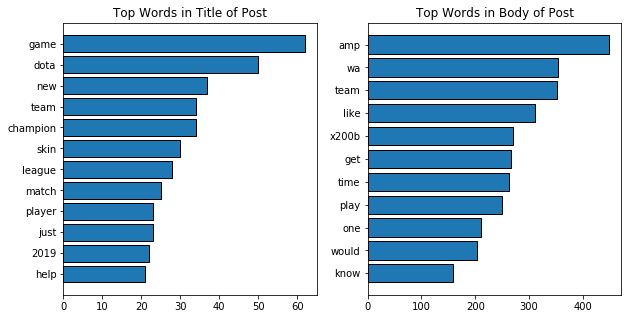

In [43]:
# Creating bar graph showing words and their count

fig = plt.figure(figsize=(10,5))

ax1= fig.add_subplot(1,2,2)
ax1.barh(top_text.index,top_text['word_count'],edgecolor='k');
ax1.set_title("Top Words in Body of Post")

ax1= fig.add_subplot(1,2,1)
ax1.barh(top_title.index,top_title['word_count'],edgecolor='k');
ax1.set_title("Top Words in Title of Post")

In [225]:
# resetting X and y values
# Setting X and y values for merged dataframe
X = df['Text']
y = df['Subreddit_leagueoflegends']

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [227]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(789,)
(264,)
(789,)
(264,)


In [257]:
# Creating pipeline for count vectorization for logistic regression
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'lr__penalty': ['l1','l2'],
    'cvec__max_features': [300, 500, 1000],
    'cvec__min_df': [0.01,0.05],
    'cvec__max_df': [0.7,0.8,0.9],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'cvec__stop_words': ['english', custom_stop_words]
}

gs_1 = GridSearchCV(pipe, param_grid = pipe_params, cv = 3, verbose = 1)
gs_1.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 36.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__penalty': ['l1', 'l2'], 'cvec__max_features': [300, 500, 1000], 'cvec__min_df': [0.01, 0.05], 'cvec__max_df': [0.7, 0.8, 0.9], 'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)], 'cvec__stop_words': ['english', ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"..., "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'uh', 'http', 'com', 'game']]},
       pre_dispatch='2*n_jobs', refit

In [256]:
# Finding best parameters as well as printing actual scores
best_gs = gs_1.best_estimator_
best_gs.fit(X_train,y_train)
y_train_preds = best_gs.predict(X_train)
y_test_preds = best_gs.predict(X_test)
print(best_gs)
print('Train score: ', accuracy_score(y_train, y_train_preds))
print('Test score: ', accuracy_score(y_test, y_test_preds))

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=500, min_df=0.01,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
      ...penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])
Train score:  0.9416983523447402
Test score:  0.8257575757575758


In [248]:
# Creating pipeline and gridsearch for logistic regression
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params_tfidf = {
    'lr__penalty': ['l1','l2'],
    'tfidf__max_features': [100, 300, 500 , 1000],
    'tfidf__min_df': [0.01,0.05],
    'tfidf__max_df': [0.8,0.9],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__stop_words': ['english', custom_stop_words]
}

gs_2 = GridSearchCV(pipe_tfidf, param_grid = pipe_params_tfidf, cv = 3, verbose = 1, n_jobs = 2)
gs_2.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   36.2s
[Parallel(n_jobs=2)]: Done 576 out of 576 | elapsed:   54.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'lr__penalty': ['l1', 'l2'], 'tfidf__max_features': [100, 300, 500, 1000], 'tfidf__min_df': [0.01, 0.05], 'tfidf__max_df': [0.8, 0.9], 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__stop_words': ['english', ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "yo..., "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'uh', 'http', 'com', 'game']]},
       pre_dispatch='2*n_jobs', refit=Tr

In [249]:
# creating pipeline for tfidf and logistic regression
best_gs_tfidf = gs_2.best_estimator_
best_gs_tfidf.fit(X_train,y_train)
y_test_preds = best_gs_tfidf.predict(X_test)
print('Train score: ', accuracy_score(y_train, y_train_preds))
print('Test score: ', accuracy_score(y_test, y_test_preds))

Train score:  0.9416983523447402
Test score:  0.8181818181818182


In [254]:
# Creating pipeline for count vectorizor and MNB
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_params_mnb = {
    'cvec__max_features': [300, 500, 1000],
    'cvec__min_df': [0.01,0.05],
    'cvec__max_df': [0.8,0.9],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'cvec__stop_words': ['english', custom_stop_words]
}

gs_3 = GridSearchCV(pipe_mnb, param_grid = pipe_params_mnb, cv = 3, verbose = 1, n_jobs = 2)
gs_3.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done 216 out of 216 | elapsed:   23.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'cvec__max_features': [300, 500, 1000], 'cvec__min_df': [0.01, 0.05], 'cvec__max_df': [0.8, 0.9], 'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)], 'cvec__stop_words': ['english', ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'yo..., "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'uh', 'http', 

In [260]:
best_gs_mnb = gs_3.best_estimator_
best_gs_mnb.fit(X_train,y_train)
y_test_preds = best_gs_tfidf.predict(X_test)
print('Train score: ', accuracy_score(y_train, y_train_preds))
print('Test score: ', accuracy_score(y_test, y_test_preds))

Train score:  0.9416983523447402
Test score:  0.8181818181818182


In [259]:
# Creating pipeline for count vectorizor and MNB
pipe_mnb_tfidf = Pipeline([
    ('tfidf', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_params_mnb_tfidf = {
    'tfidf__max_features': [300, 500, 1000],
    'tfidf__min_df': [0.01,0.05],
    'tfidf__max_df': [0.8,0.9],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__stop_words': ['english', custom_stop_words]
}

gs_4 = GridSearchCV(pipe_mnb_tfidf, param_grid = pipe_params_mnb_tfidf, cv = 3, verbose = 1, n_jobs = 2)
gs_4.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   21.7s
[Parallel(n_jobs=2)]: Done 216 out of 216 | elapsed:   23.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'tfidf__max_features': [300, 500, 1000], 'tfidf__min_df': [0.01, 0.05], 'tfidf__max_df': [0.8, 0.9], 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__stop_words': ['english', ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd"..., "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'uh', 'http',

In [261]:
best_gs_mnb = gs_4.best_estimator_
best_gs_mnb.fit(X_train,y_train)
y_test_preds = best_gs_tfidf.predict(X_test)
print('Train score: ', accuracy_score(y_train, y_train_preds))
print('Test score: ', accuracy_score(y_test, y_test_preds))

Train score:  0.9416983523447402
Test score:  0.8181818181818182
